In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pickle

from dqn_pendulum import DQNAgent, StateNormalizer
import gymnasium as gym

from utils import load_agent, generate_trajectory

In [4]:
dqn_rewards = pd.read_csv("./dqn_rewards_5000.csv")
dqn_rewards.describe()

,Episode,Reward
count,5000.000000,5000.000000
mean,2500.500000,-792.965625
std,1443.520003,276.434717
min,1.000000,-1850.960940
25%,1250.750000,-906.583216
50%,2500.500000,-714.814016
75%,3750.250000,-587.486177
max,5000.000000,-78.384112


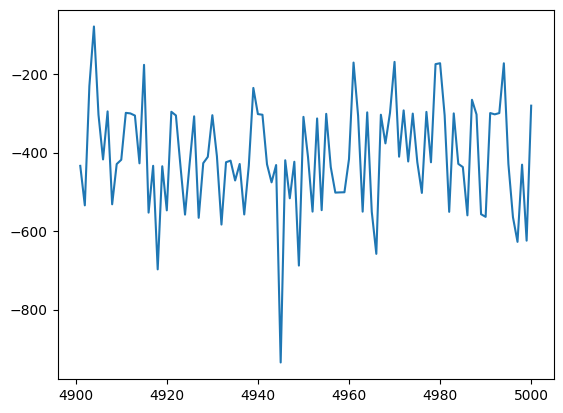

In [5]:
plt.plot(dqn_rewards["Episode"][4900:], dqn_rewards["Reward"][4900:])
plt.show()

In [6]:
# Action space (same as training)
action_space = np.linspace(-2.0, 2.0, 50)  # Pendulum-v1: [-2, 2]

# Load pi_1 (best policy)
pi_1 = load_agent("/home/thai/rlhf/checkpoints_dqn_5000/dqn_checkpoint_episode_best_at_4904.pt", state_dim=3, action_space=action_space)

# Load pi_2 (epoiso)
pi_2 = load_agent("/home/thai/rlhf/checkpoints_dqn_5000/dqn_checkpoint_episode_best_at_4903.pt", state_dim=3, action_space=action_space)

In [7]:
env = gym.make('Pendulum-v1')

K = 1000
preference_dataset = []
for pair_id in tqdm(range(K), desc="Generating preference dataset"):
    tau_1, R_tau_1 = generate_trajectory(pi_1, env) # tau_1: [(state: shape(3,), action_idx, action, reward)] * 200 times
    tau_2, R_tau_2 = generate_trajectory(pi_2, env)
    clip_threshold = 80  # 80 < 87; exp(-87) ~ 1e-38
    max_reward = max(R_tau_1, R_tau_2)
    safe_reward_1 = np.clip(R_tau_1 - max_reward, -clip_threshold, clip_threshold)
    safe_reward_2 = np.clip(R_tau_2 - max_reward, -clip_threshold, clip_threshold)
    prob = np.exp(safe_reward_1) / (np.exp(safe_reward_1) + np.exp(safe_reward_2))
    preferred_label = 1 if np.random.rand() < prob else 0
    preferred = tau_1 if preferred_label == 1 else tau_2
    rejected = tau_2 if preferred_label == 1 else tau_1
    preference_dataset.append((preferred, rejected))

Generating preference dataset:   0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:
with open('preference_dataset.pkl', 'wb') as f:
    pickle.dump(preference_dataset, f)

In [12]:
with open('preference_dataset.pkl', 'rb') as f:
    xxx = pickle.load(f)

In [15]:
len(xxx[0])

2

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for preferred_traj, rejected_traj in tqdm(xxx):
    # Process preferred trajectory
    states_pref = torch.FloatTensor([step[0] for step in preferred_traj]).to(device)
    actions_pref = torch.LongTensor([step[1] for step in preferred_traj]).to(device)

  0%|          | 0/1000 [00:00<?, ?it/s]